# HyAsP results on Enterococcus faecalis data
### Cedric Chauve, August 17 2020

This notebook describes the results of HyAsP, with a novel plasmids database generated from the 203 release of RefSeq, on a set of *E. faecalis* samples.

In [1]:
import sys
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import collections
from collections import defaultdict
import math

In [2]:
# Plotting functions

# Bubble plot of two columns of a dataframe
def bubble_plot(df,col1,col2,title,size=1,fs=(10,5),line=False):
    plt.figure(figsize=fs)
    n = len(col1)
    for i in range(n):
        plt.subplot(1,n,i+1)
        X = df[col1[i]]
        Y = df[col2[i]]
        XY = [(X[j],Y[j]) for j in X.keys()]
        XY_count=collections.Counter(XY)
        XX,YY,ZZ = [],[],[]
        for (x,y),z in XY_count.items():
            XX.append(x)
            YY.append(y)
            ZZ.append(z)
        if line:
            lineStart = np.array(XX).min() 
            lineEnd   = np.array(XX).max()  
            plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
        plt.scatter(np.array(XX),np.array(YY),s=np.array(ZZ)*size,alpha=0.5)
        plt.xlabel(col1[i])
        plt.ylabel(col2[i])
        plt.title(title[i])
    plt.show()
    
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", rotation=0, **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = rotation)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return(axe)

# Data and results

### HyAsP databases.
I generated two plasmid databses for HyAsP, both based on the latest release (203) of RefSeq:
- the first one (full database) contains all plasmid genes,
- the second one (limited database) contains only genes from *Enterococcus faecalis* genomes from RefSeq 203.

The databases were built with minimal filtering, which might need to be revisited, and are described in a separate notebook 
[here](../RefSeq/RefSeq203.ipynb).

### Enterococcus samples.
I analysed the samples provided with assembly graphs in the GFA format. The samples names are listed in the file [here](./GFA.txt). The GFA files are available in the directory *../McMaster/Unicycler_Assemblies_gfa*.

### HyAsP results.
The results are in the directory *./results*, with two directories per sample, one for the results with the full database and one for the results for the limited database.

In each directory, the important files are 
- *[SAMPLE_NAME]_assembly_filtered_gcm.csv*: mapping of the database plasmid genes onto the contigs, filtered out to keep only the mapping that cover at least 95% of the gene length with 95% identity; note that the genes come from GenBank and the gene names correspond to the tag *locus_tag* of GenBank entries. It follows the <a href="http://www.metagenomics.wiki/tools/blast/blastn-output-format-6">tabular output format of BLASTn</a>.
- *contig_chains.csv*: contigs order and orientation of each putative and questionable plasmid.
- *putative_plasmids.fasta*: sequence of each putative plasmid.
- *putative_plasmid_contigs.fasta*: same as above but broken into contigs.
- *questionable_plasmids.fasta*: sequence of each questionable plasmid.
- *questionable_plasmid_contigs.fasta*: same as above but broken into contigs.

In [3]:
# Reading the sample names
RESULTS_DIR  = './results'
GFA_FILE     = './GFA.txt'
SAMPLE_NAMES = [s.rstrip() for s in open(GFA_FILE,'r').readlines()]

A preliminary analysis showed that there is one sample that has a lot of predicted plasmids with a large cumulated length. This is sample ES-C-ST001-07DEC15-0141J_assembly that has 295 predicted plasmids, and we remove it from the analysis from now.

In [4]:
SAMPLE_NAMES.remove('ES-C-ST001-07DEC15-0141J_assembly')

In [5]:
# Reading results: functions
DF_COLUMNS = ['name','seed','length','num_cds','mean_read_depth','gene_density','gc_content','putative','circular']

def read_plasmid_features(f):
    data = open(f,'r').readlines()
    output={}
    for plasmid in data:
        if plasmid[0]=='>':
            plasmid_data = plasmid.rstrip().replace('>','').split('\t')
            plasmid_name = plasmid_data[0].split()[0]
            plasmid_seed = plasmid_data[0].split()[1].split('=')[1]
            output[plasmid_name] = {'name':plasmid_name,'seed':plasmid_seed}
            for feature in plasmid_data[1:]:
                field = feature.split('=')[0]
                if field in ['length','num_cds']:
                    value = int(feature.split('=')[1])
                elif field in ['mean_read_depth','gene_density','gc_content']:
                    value = float(feature.split('=')[1])
                elif field == 'circular':
                    value = feature.split('=')[1] == '1'
                else:
                    value = feature.split('=')[1]
                output[plasmid_name][field]=value
    return(output)

def read_sample_results(s):
    plasmids = {}
    # Read contig chains
    with open(RESULTS_DIR+'/'+s+'/contig_chains.csv') as csvfile:
        contig_chains_data = csv.reader(csvfile,delimiter=';')
        for plasmid in contig_chains_data:
            plasmids[plasmid[0]]={'chain':plasmid[1]}            
    # Read plasmids
    def read_features_aux(pref):
        plasmids_file = RESULTS_DIR+'/'+s+'/'+pref+'_plasmids.fasta'
        plasmids_data = read_plasmid_features(plasmids_file)
        for plasmid_name in plasmids_data.keys():
            plasmids[plasmid_name]['putative']=pref=='putative'
            for field,value in plasmids_data[plasmid_name].items():
                plasmids[plasmid_name][field]=value
    # Read putative plasmids
    read_features_aux('putative')
    # Read questionable plasmids
    read_features_aux('questionable')
    # return dataframe
    if len(plasmids.keys())==0:
        return(pd.DataFrame(columns=DF_COLUMNS))
    else:
        return(pd.DataFrame.from_dict(plasmids,orient='index'))

# Access functions        
def sample_nb_plasmids(df):
    if df.shape[0]==0:
        return(0)
    else:
        return(df.loc[df['putative']==True].shape[0])
    
def sample_nb_circ_plasmids(df):
    if df.shape[0]==0:
        return(0)
    else:
        return(df.loc[(df['putative']==True) & (df['circular']==True)].shape[0])
        
def extract_putative_plasmids(df):
    return(df.loc[df['putative']==True])

def extract_questionable_plasmids(df):
    return(df.loc[df['putative']==False])

def contigs_multiset(df):
    result = []
    for chain in df['chain'].values:
        contigs = chain.replace('+','').replace('-','').split(',')
        result += contigs
    return(result)

In [6]:
# Reading results
RESULTS_CSV_DONE = False
AUX_FILES_DIR    = 'aux_files'

if RESULTS_CSV_DONE == False:
    RESULTS_FULL_DF = {}
    RESULTS_LIM_DF  = {}
    for sample in SAMPLE_NAMES:
        RESULTS_FULL_DF[sample] = read_sample_results(sample)
        RESULTS_FULL_DF[sample].to_csv(AUX_FILES_DIR+'/'+sample+'_summary.csv')
        RESULTS_LIM_DF[sample]  = read_sample_results(sample+'_Efaecalis')
        RESULTS_LIM_DF[sample].to_csv(AUX_FILES_DIR+'/'+sample+'_Efaecalis_summary.csv')
    RESULTS_CSV_DONE = True
else:
    RESULTS_FULL_DF = {}
    RESULTS_LIM_DF  = {}
    for sample in SAMPLE_NAMES:
        RESULTS_FULL_DF[sample] = pd.read_csv(AUX_FILES_DIR+'/'+sample+'_summary.csv') 
        RESULTS_LIM_DF[sample]  = pd.read_csv(AUX_FILES_DIR+'/'+sample+'_Efaecalis_summary.csv')
        
NO_PUT_PLASMID_FULL,NO_PUT_PLASMID_LIM = [],[]
for sample in SAMPLE_NAMES:
    df = RESULTS_FULL_DF[sample]
    if len(df.loc[df['putative']==True].index)==0:
        NO_PUT_PLASMID_FULL.append(sample)
    df = RESULTS_LIM_DF[sample]
    if len(df.loc[df['putative']==True].index)==0:
        NO_PUT_PLASMID_LIM.append(sample)
        
print('There are '+str(len(NO_PUT_PLASMID_FULL))+' samples with no predicted putative plasmid with the full database.')
print('There are '+str(len(NO_PUT_PLASMID_LIM))+' samples with no predicted putative plasmid with the limited database')

There are 7 samples with no predicted putative plasmid with the full database.
There are 52 samples with no predicted putative plasmid with the limited database


From now, we concentrate on the putative plasmids only.

We create a summary file for the putative plasmids in each analyzed sample that is located in the directory *aux_files*. It shows, for each predicted plasmid, the following features: contig chain, whether it is putative or not, whtther it is circular or not, its length, seed contig, mean read depth, plasmids gene density (from the RefSeq 203 plasmids database), mean GC content, as well as the number of CDS found on its contigs during the plasmids genes mapping phase of HyAsP.

In [8]:
# Summarizing results
SUMMARY_CSV_DONE = False

# Mapping function on the individual samples fields to generate the summary
SUMMARY_MAP_DICT = {
    'num_plasmids': lambda df: df.shape[0],
    'sum_length':   lambda df: sum([l for l in df['length'].values]),
    'lengths':      lambda df: [l for l in df['length'].values],
    'num_contigs':  lambda df: sum([len(chain.split(',')) for chain in df['chain'].values]),
    'num_cds':      lambda df: sum([cds for cds in df['num_cds'].values]),
    'read_depth':   lambda df: [rd for rd in df['mean_read_depth'].values],
    'gene_density': lambda df: [gd for gd in df['gene_density'].values],
    'gc_content':   lambda df: [gc for gc in df['gc_content'].values]
} 
SUMMARY_FIELDS = [key+'_full' for key in SUMMARY_MAP_DICT.keys()] + [key+'_lim' for key in SUMMARY_MAP_DICT.keys()]

# Init a summary entry with default values
def init_summary_sample(s,summary_dict):
    summary_dict[s]['name'] = s
    for field in ['num_plasmids','sum_length','num_contigs','num_cds']:
        summary_dict[s][field+'_full'],summary_dict[s][field+'_lim'] = 0,0
    for field in ['lengths','read_depth','gene_density','gc_content']:
        summary_dict[s][field+'_full'],summary_dict[s][field+'_lim'] = [],[]

if SUMMARY_CSV_DONE == False:
    SUMMARY_DICT = {sample:{} for sample in SAMPLE_NAMES}
    for sample in SAMPLE_NAMES:
        # Initialisation to default values corresponding to no putative plasmids
        init_summary_sample(sample,SUMMARY_DICT)
        # Reading individual samples results
        if sample_nb_plasmids(RESULTS_FULL_DF[sample])>0:
            for field,fmap in SUMMARY_MAP_DICT.items():
                SUMMARY_DICT[sample][field+'_full'] = fmap(extract_putative_plasmids(RESULTS_FULL_DF[sample]))
        if sample_nb_plasmids(RESULTS_LIM_DF[sample])>0:
            for field,fmap in SUMMARY_MAP_DICT.items():
                SUMMARY_DICT[sample][field+'_lim'] = fmap(extract_putative_plasmids(RESULTS_LIM_DF[sample]))
    # Final output
    SUMMARY_DF = pd.DataFrame.from_dict(SUMMARY_DICT,orient='index')
    SUMMARY_DF.to_csv(AUX_FILES_DIR+'/summary.csv')
    SUMMARY_CSV_DONE = True
else:
    SUMMARY_DF = pd.read_csv(AUX_FILES_DIR+'/summary.csv')

## Analysis

We first look at a comparison, for all samples, of the putative plasmids predicted with both databases, the full one and the limited one.

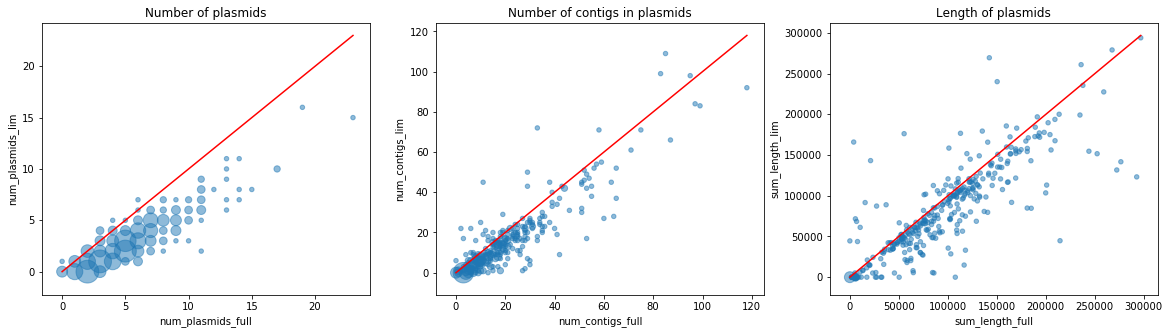

In [9]:
bubble_plot(SUMMARY_DF,
            ['num_plasmids_full','num_contigs_full','sum_length_full'],
            ['num_plasmids_lim','num_contigs_lim','sum_length_lim'],
            ['Number of plasmids','Number of contigs in plasmids','Length of plasmids'],
            fs=(20,5),size=20,line=True)

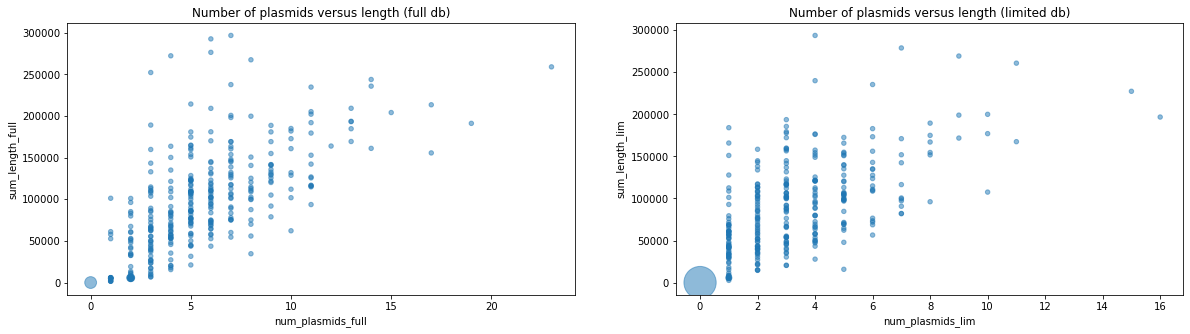

In [10]:
bubble_plot(SUMMARY_DF,
            ['num_plasmids_full','num_plasmids_lim'],
            ['sum_length_full','sum_length_lim'],
            ['Number of plasmids versus length (full db)','Number of plasmids versus length (limited db)'],
            fs=(20,5),size=20)

We can see that generally, predicting from the full database results in a larger number of plasmids, plasmids length for some samples, working with the limited databases results in a larger number of predicted plasmids and/or a larger predicted plasmids boh in terms of the number of contigs in the chains and their cumulated length. This was expected although it is not clear whether we observe that plasmids predicted as separate with the limited database are fused when using the larger database. This question takes us back to the problem of comparing two sets of predicted plasmids.

We list below the few samples where working with the limited database results in more plasmids or plasmids of larger cumulated length.

In [11]:
print('Samples where there are less plasmids with the full database than with the limited:')
MORE_PLASMIDS_WITH_LIM, LONGER_PLASMIDS_WITH_LIM = [], []
for sample in SAMPLE_NAMES:
    num_plasmids_full = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['num_plasmids_full'].values[0]
    num_plasmids_lim  = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['num_plasmids_lim'].values[0]
    if num_plasmids_full<num_plasmids_lim:
        MORE_PLASMIDS_WITH_LIM.append((sample,num_plasmids_lim-num_plasmids_full))
MORE_PLASMIDS_WITH_LIM.sort(key=lambda x:x[1], reverse=True)
for (sample,diff) in MORE_PLASMIDS_WITH_LIM:
    print('\t',sample,'\tdifference: ',diff)
print('Samples where the full database plasmids are shorter overall than the limited database plasmids:')
for sample in SAMPLE_NAMES:
    lg_full = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['sum_length_full'].values[0]
    lg_lim  = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['sum_length_lim'].values[0]
    if lg_full<lg_lim:
        LONGER_PLASMIDS_WITH_LIM.append((sample,lg_lim-lg_full))
LONGER_PLASMIDS_WITH_LIM.sort(key=lambda x:x[1], reverse=True)
for (sample,diff) in LONGER_PLASMIDS_WITH_LIM:
    print('\t',sample,'\tdifference: ',diff)

Samples where there are less plasmids with the full database than with the limited:
	 ES-C-ST001-05OCT15-0134I_assembly 	difference:  1
	 ES-M-ST001-13OCT14-0050I_assembly 	difference:  1
	 ES-M-ST001-19MAY15-0089E_assembly 	difference:  1
	 ES-M-ST001-21JUL14-0029K_assembly 	difference:  1
	 NS-0228_assembly 	difference:  1
	 NS-1131_assembly 	difference:  1
Samples where the full database plasmids are shorter overall than the limited database plasmids:
	 NS-0340_assembly 	difference:  162058
	 NS-0332_assembly 	difference:  127130
	 SS-0008_assembly 	difference:  122028
	 NS-1131_assembly 	difference:  120867
	 NS-1184_assembly 	difference:  89807
	 SS-0004_assembly 	difference:  76092
	 ES-C-ST001-05OCT15-0134J_assembly 	difference:  66061
	 NS-0004_assembly 	difference:  63816
	 ES-C-ST001-01FEB16-0145M_assembly 	difference:  61640
	 NS-0209_assembly 	difference:  60096
	 NS-1289_assembly 	difference:  57476
	 BP-R50-2_assembly 	difference:  51937
	 BP-R19-2_assembly 	difference:  

We can observe that the difference in number of plasmids is at most 1, but the cumulated length difference goes up to 160kb, which is a lot.

We now look at the number of circular predicted plasmids and show all the samples with at least one circular plasmid

In [13]:
WITH_CIRCULAR_PLASMIDS = []
for sample in SAMPLE_NAMES:
    nb_circ_full = sample_nb_circ_plasmids(RESULTS_FULL_DF[sample])
    nb_circ_lim  = sample_nb_circ_plasmids(RESULTS_LIM_DF[sample])
    if nb_circ_lim>0 or nb_circ_full>0:
        WITH_CIRCULAR_PLASMIDS.append((sample,nb_circ_full,nb_circ_lim))
print('There are '+str(len(WITH_CIRCULAR_PLASMIDS))+' samples with at least one circular plasmid whether with the full or limited database.')
for (sample,nb_circ_full,nb_circ_lim) in WITH_CIRCULAR_PLASMIDS:
    print('\t',sample,'\tfull db: ',nb_circ_full,' circular plasmids\t-\tlimited db: ',nb_circ_lim,' circular plasmids\t-\t difference:'+str(nb_circ_full-nb_circ_lim))

There are 157 samples with at least one circular plasmid whether with the full or limited database.
	 BP-G109-2_assembly 	full db:  1  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:0
	 BP-G138E-2_assembly 	full db:  2  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:1
	 BP-G149-3_assembly 	full db:  1  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:0
	 BP-G42-1_assembly 	full db:  1  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:0
	 BP-G69E-3_assembly 	full db:  1  circular plasmids	-	limited db:  0  circular plasmids	-	 difference:1
	 BP-H22-1_assembly 	full db:  0  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:-1
	 BP-H4-1_assembly 	full db:  3  circular plasmids	-	limited db:  2  circular plasmids	-	 difference:1
	 BP-H44-3_assembly 	full db:  1  circular plasmids	-	limited db:  1  circular plasmids	-	 difference:0
	 BP-H96E-2_assembly 	full db:  1  circular plasmids	-	limited 

Now we look at the distribution of the length of the putative plasmids for each sample. To have figures that are not too packed, we split the samples into subgroups based on their names and for each sample we show to stacked bars (full database on the left, limited database on the right) with one colored segment per predicted putative plasmid of height propertional to its length.

In [15]:
# To have figures that are not too packed, we split the samples into subgroups based on their names
PREFIXES = ['BP', 'En', 'ES', 'ES-C', 'ES-M', 'NS', 'SS', 'SW']

def sample_prefix(sample):
    prefix = sample[0:4]
    if prefix not in PREFIXES:
        prefix = sample[0:2]
    return(prefix)

In [16]:
# Stacked bar chart of the plasmids and their length
# Gathering actual lengths
PLASMIDS_LG_FULL_DICT = {prefix: {} for prefix in PREFIXES}
PLASMIDS_LG_LIM_DICT = {prefix: {} for prefix in PREFIXES}

for sample in SAMPLE_NAMES:
    prefix = sample_prefix(sample)
    PLASMIDS_LG_FULL_DICT[prefix][sample] = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['lengths_full'].values[0]
    PLASMIDS_LG_LIM_DICT[prefix][sample] = SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['lengths_lim'].values[0]
# Maximum number of plasmids
MAX_NUM_PLASMIDS_FULL = max(SUMMARY_DF['num_plasmids_full'])
MAX_NUM_PLASMIDS_LIM  = max(SUMMARY_DF['num_plasmids_lim'])
MAX_NUM_PLASMIDS = max([MAX_NUM_PLASMIDS_FULL,MAX_NUM_PLASMIDS_LIM])
# Completing each length list by zeros to have the same number of entries in each list
for sample in SAMPLE_NAMES:
    prefix = sample_prefix(sample)
    nb_zeros_full = MAX_NUM_PLASMIDS-len(PLASMIDS_LG_FULL_DICT[prefix][sample])
    for i in range(nb_zeros_full):
        PLASMIDS_LG_FULL_DICT[prefix][sample].append(0)
    PLASMIDS_LG_FULL_DICT[prefix][sample].sort(reverse=True)
    nb_zeros_lim = MAX_NUM_PLASMIDS-len(PLASMIDS_LG_LIM_DICT[prefix][sample])
    for i in range(nb_zeros_lim):
        PLASMIDS_LG_LIM_DICT[prefix][sample].append(0)
    PLASMIDS_LG_LIM_DICT[prefix][sample].sort(reverse=True)
# Creating dataframes
PLASMIDS_LG_FULL_DF = {}
PLASMIDS_LG_LIM_DF = {}
for prefix in PREFIXES:
    PLASMIDS_LG_FULL_DF[prefix] = pd.DataFrame.from_dict(PLASMIDS_LG_FULL_DICT[prefix],orient='index')
    PLASMIDS_LG_LIM_DF[prefix] = pd.DataFrame.from_dict(PLASMIDS_LG_LIM_DICT[prefix],orient='index')

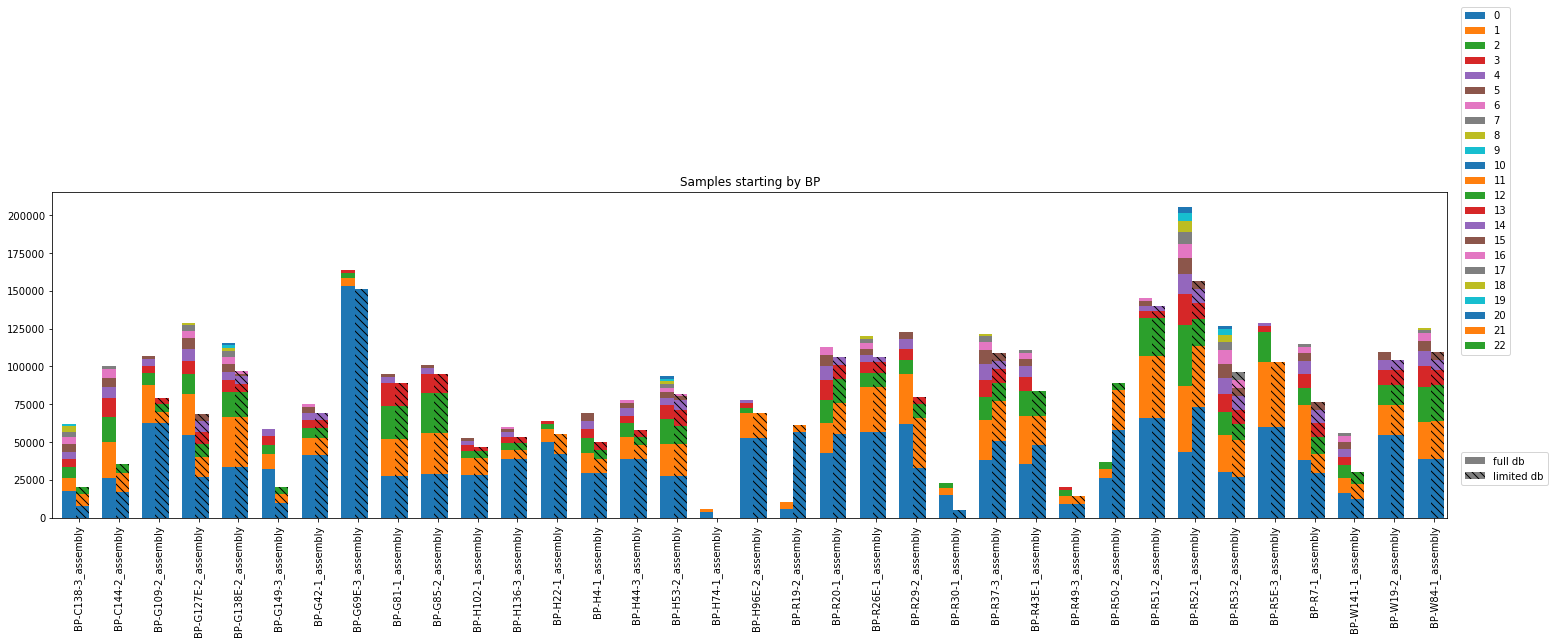

In [17]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['BP'],PLASMIDS_LG_LIM_DF['BP']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by BP')

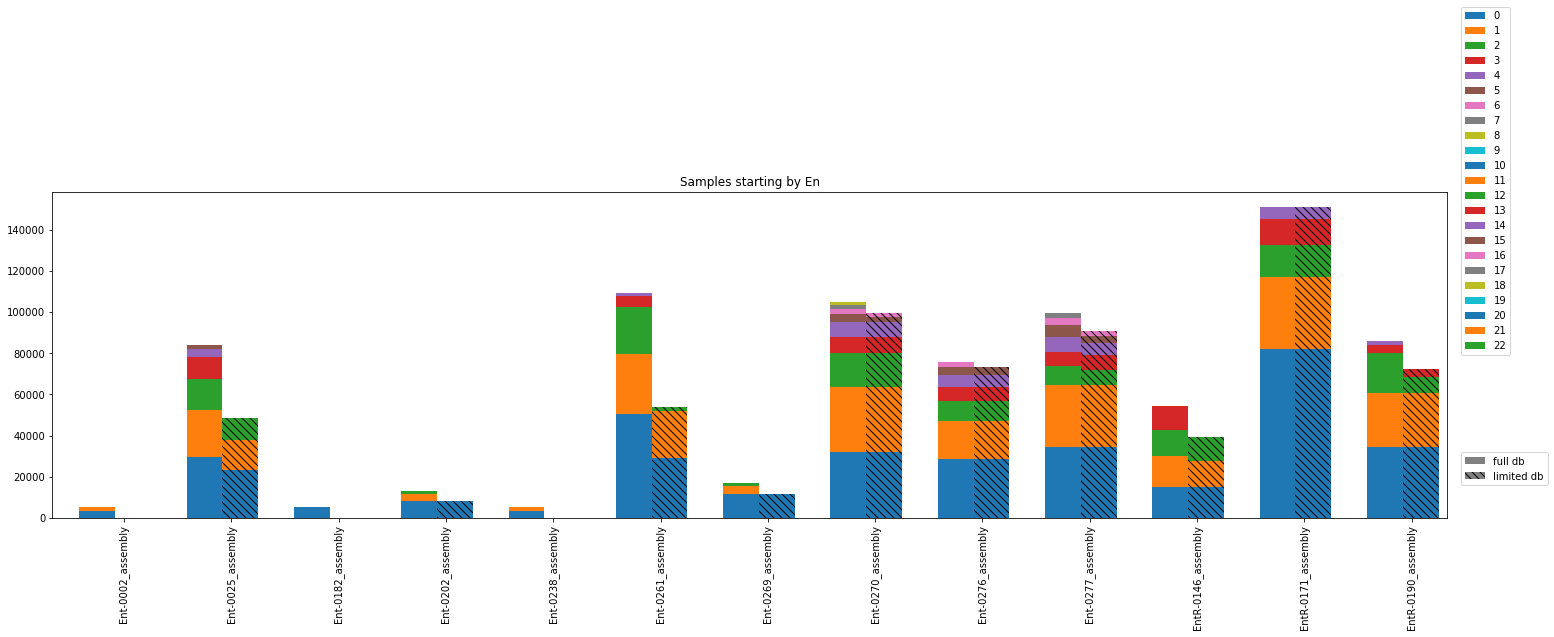

In [18]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['En'],PLASMIDS_LG_LIM_DF['En']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by En')

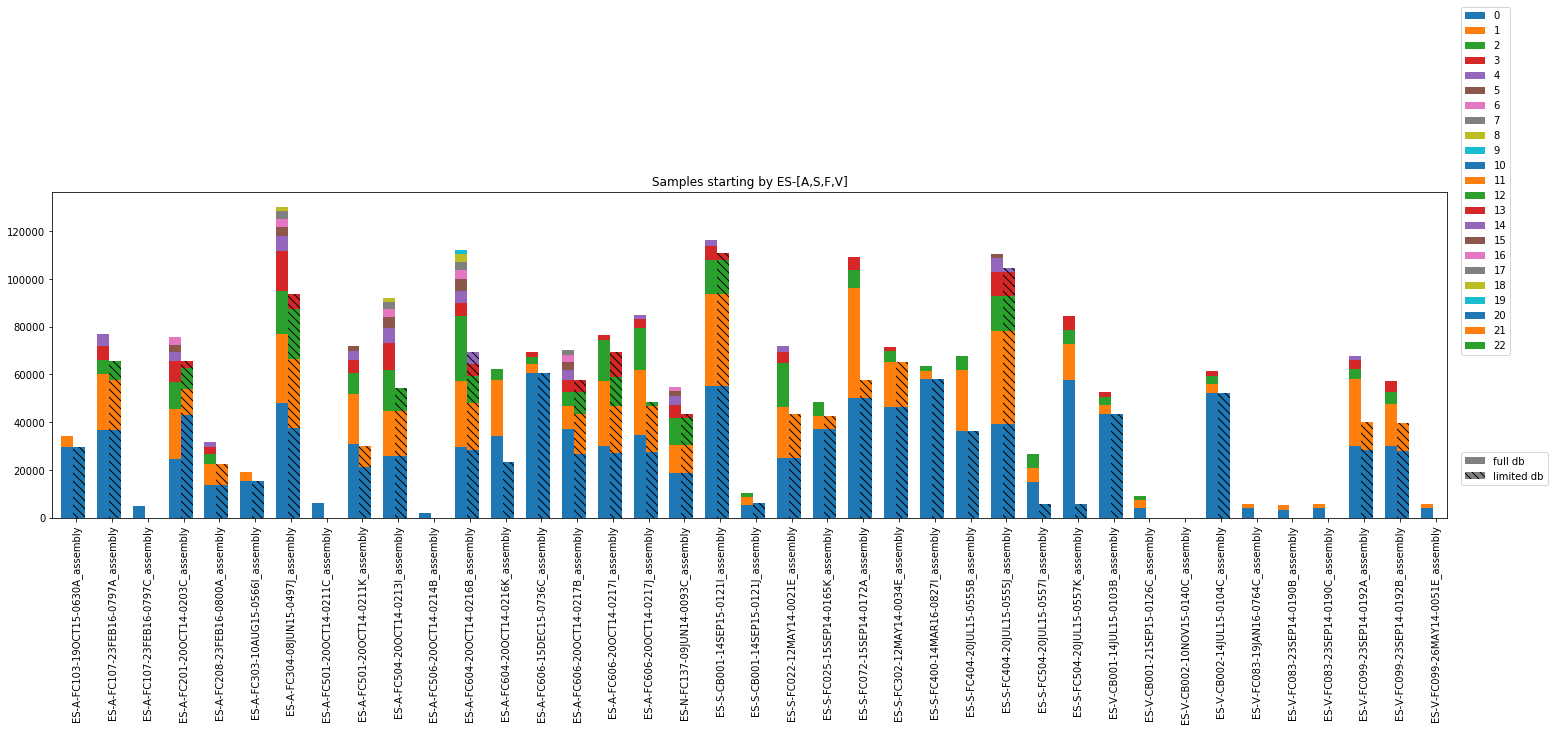

In [19]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['ES'],PLASMIDS_LG_LIM_DF['ES']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by ES-[A,S,F,V]')

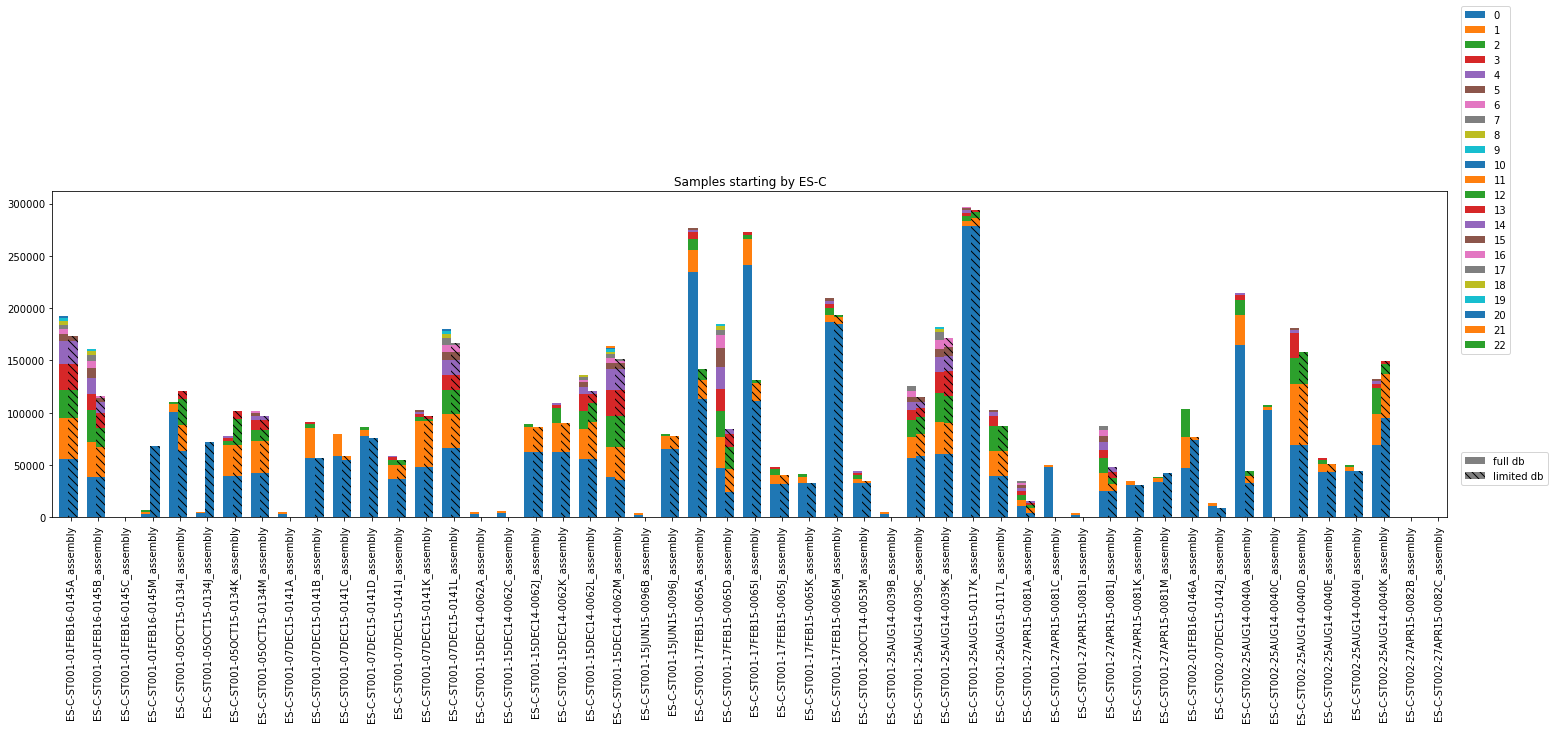

In [20]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['ES-C'],PLASMIDS_LG_LIM_DF['ES-C']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by ES-C')

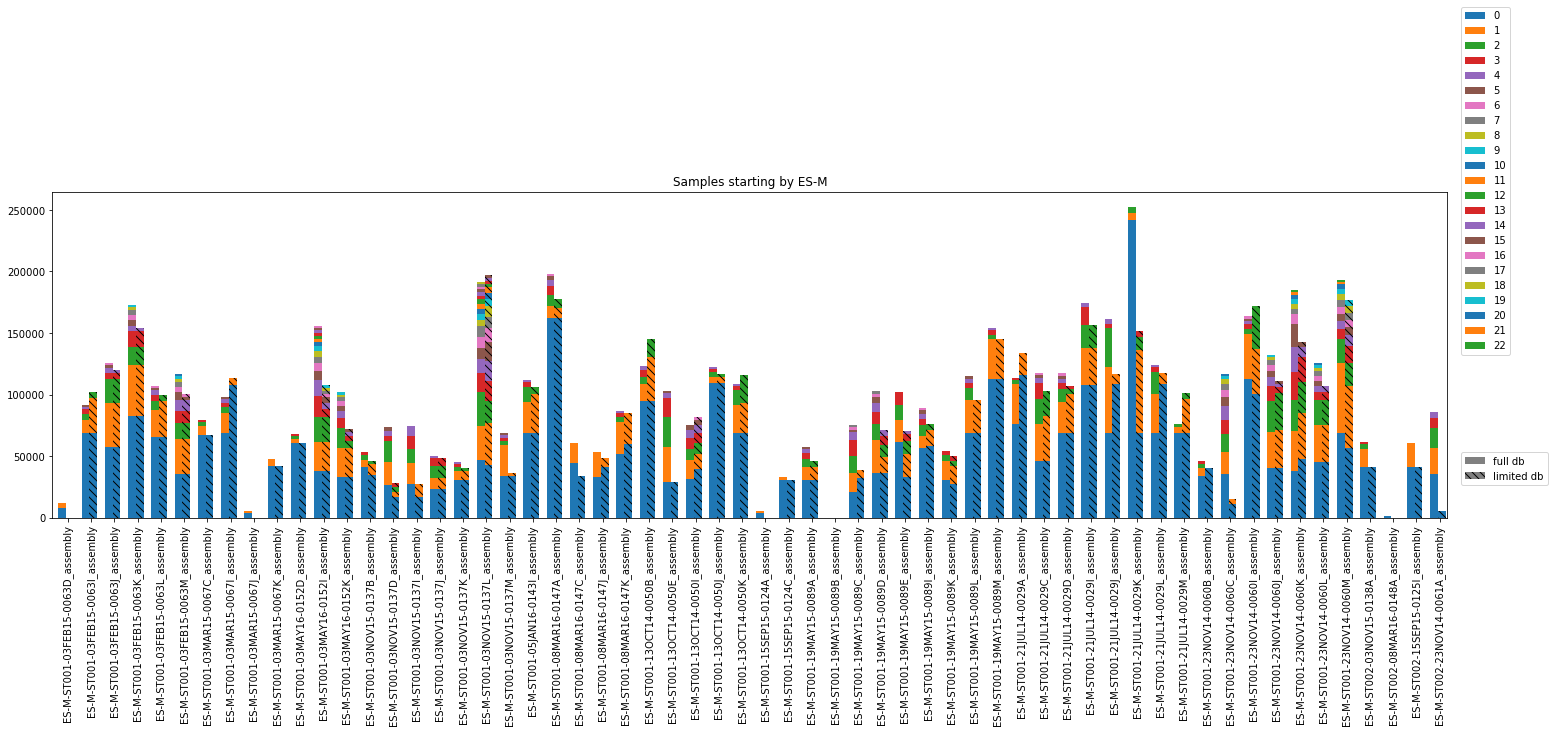

In [21]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['ES-M'],PLASMIDS_LG_LIM_DF['ES-M']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by ES-M')

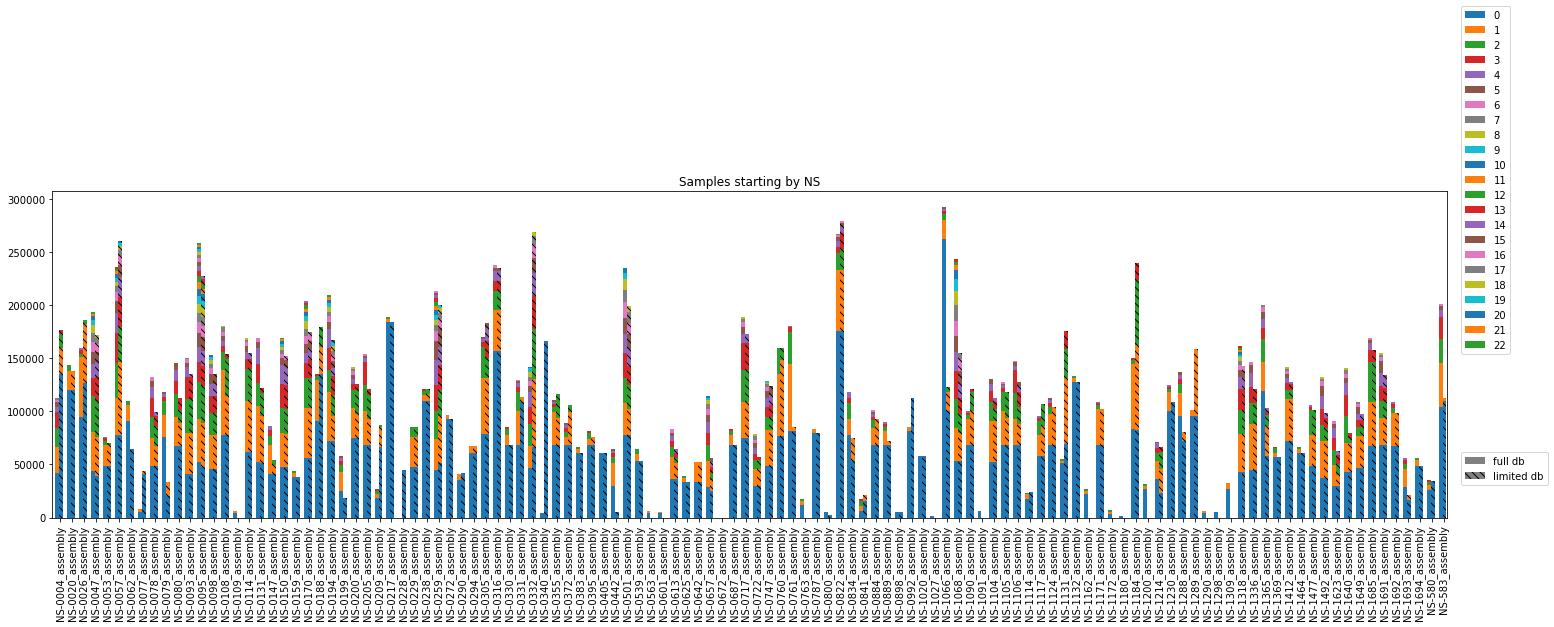

In [22]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['NS'],PLASMIDS_LG_LIM_DF['NS']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by NS')

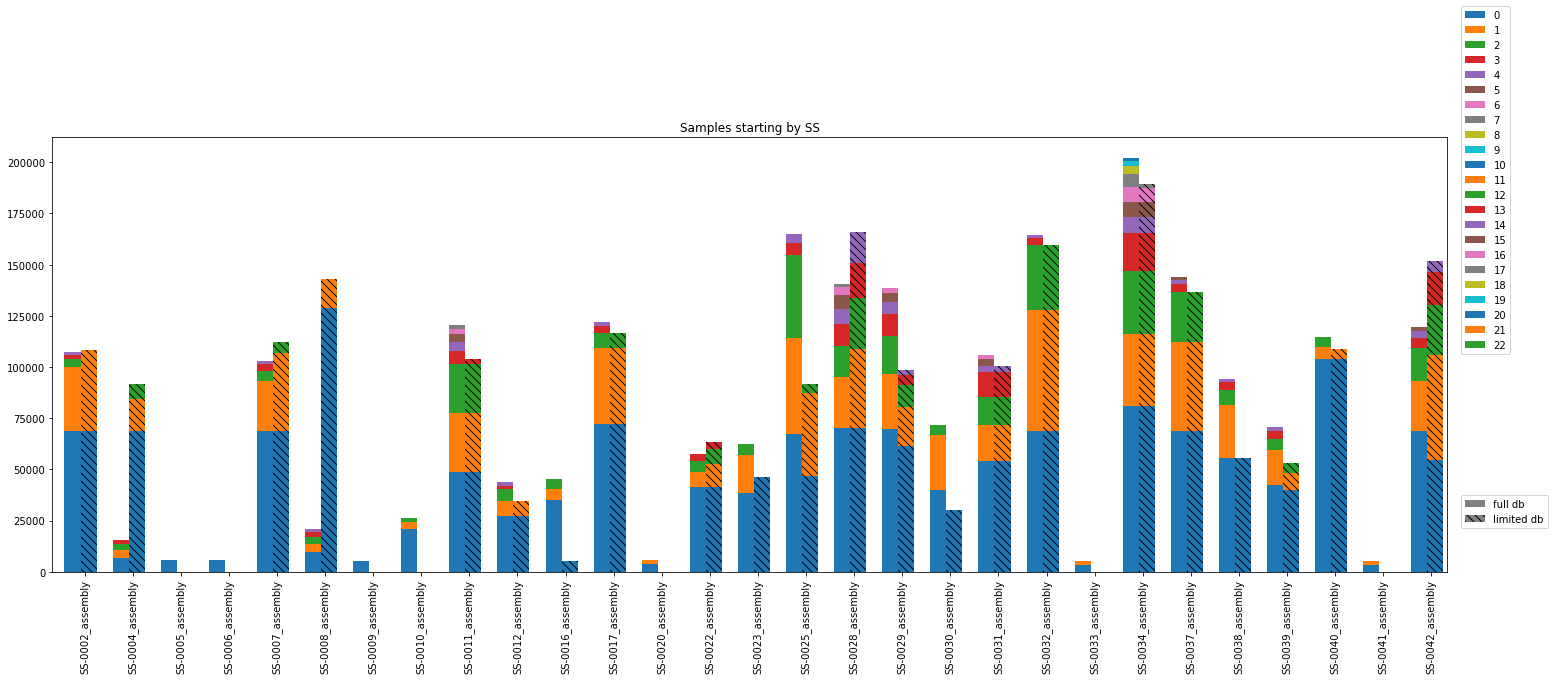

In [23]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['SS'],PLASMIDS_LG_LIM_DF['SS']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,8), title='Samples starting by SS')

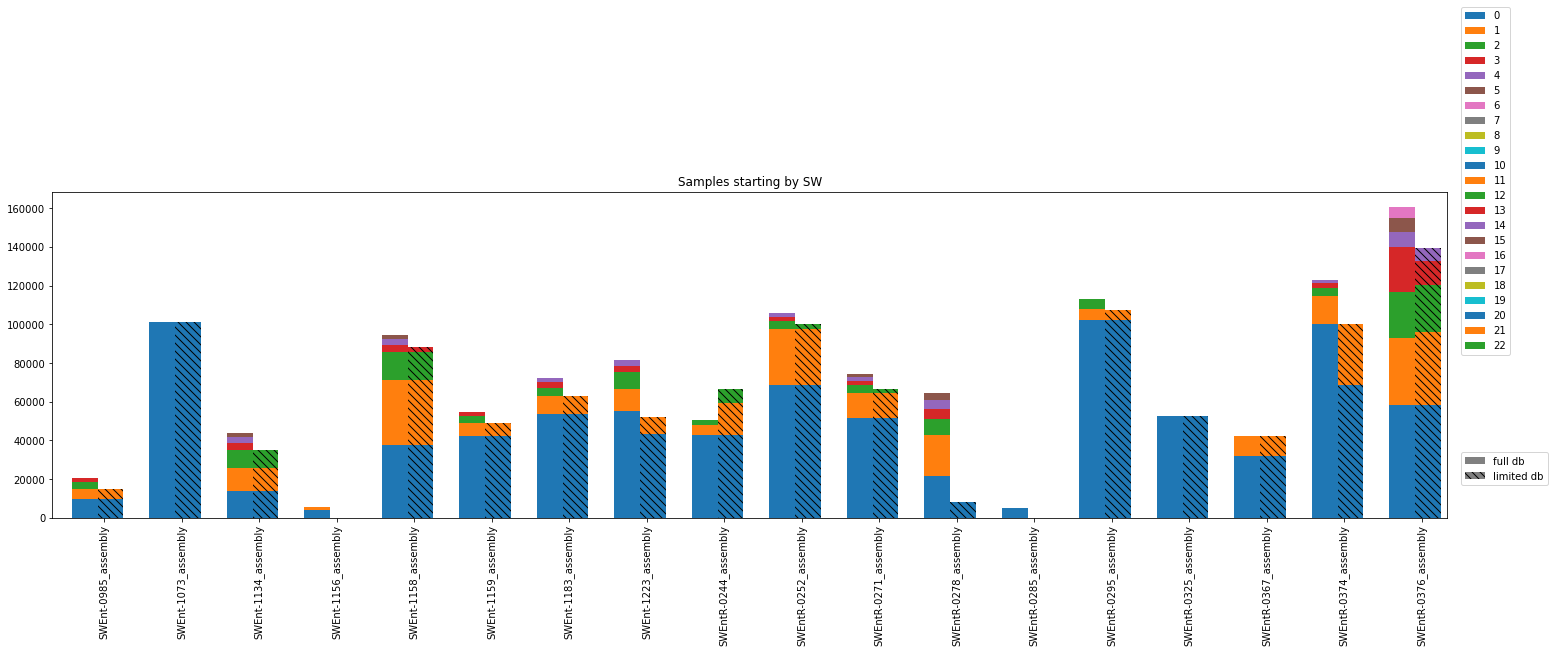

In [24]:
plot_clustered_stacked([PLASMIDS_LG_FULL_DF['SW'],PLASMIDS_LG_LIM_DF['SW']],['full db','limited db'],H='\\\\\\',rotation=90,figsize=(25,6), title='Samples starting by SW')

Overall there seems to be some good agreement between the plasmids obtained with the two databases. To assess this, we look at the difference in terms of contigs content and length of predicted plasmids.

In [25]:
# Differences between the results obtained with the two databases
def contigs_multiset_difference(sample):
    if sample_nb_plasmids(RESULTS_FULL_DF[sample]) > 0:
        a = collections.Counter(contigs_multiset(RESULTS_FULL_DF[sample].loc[RESULTS_FULL_DF[sample]['putative']==True]))
    else:
        a = collections.Counter([])
    if sample_nb_plasmids(RESULTS_LIM_DF[sample]) > 0:
        b = collections.Counter(contigs_multiset(RESULTS_LIM_DF[sample].loc[RESULTS_LIM_DF[sample]['putative']==True]))
    else:
        b = collections.Counter([])
    difference = a - b
    return(sum(difference.values()))  # Remove this line if you want it as a list

def plasmids_length_difference(sample):
    return(abs(SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['sum_length_full'].values[0]-SUMMARY_DF.loc[SUMMARY_DF['name']==sample]['sum_length_lim'].values[0]))

In [26]:
DIFFERENCE_PLASMIDS_DICT = {sample:{'num_contigs':0,'length':0} for sample in SAMPLE_NAMES}
for sample in SAMPLE_NAMES:
    DIFFERENCE_PLASMIDS_DICT[sample]['num_contigs'] = contigs_multiset_difference(sample)
    DIFFERENCE_PLASMIDS_DICT[sample]['length']      = plasmids_length_difference(sample)
DIFFERENCE_PLASMIDS_DF = pd.DataFrame.from_dict(DIFFERENCE_PLASMIDS_DICT,orient='index')

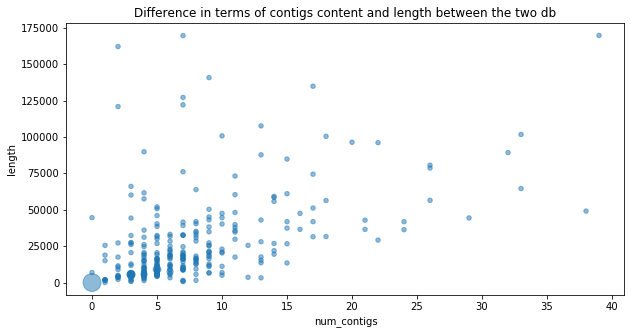

In [27]:
bubble_plot(DIFFERENCE_PLASMIDS_DF,
            ['num_contigs'],
            ['length'],
            ['Difference in terms of contigs content and length between the two db'],
            fs=(10,5),size=20)

There is a concentration close to the origin, corresponding to cases where the difference between the two databases is not too signiifcant, but there are quite a few cases where the difference is very large, both in terms of contigs content and of length. We list these cases below.

In [29]:
for sample in SAMPLE_NAMES:
    if DIFFERENCE_PLASMIDS_DICT[sample]['num_contigs']>=10 or DIFFERENCE_PLASMIDS_DICT[sample]['length']>=50000:
        print(sample+'\t- difference in number of contigs: '+str(DIFFERENCE_PLASMIDS_DICT[sample]['num_contigs'])+'\t- difference in length: '+str(DIFFERENCE_PLASMIDS_DICT[sample]['length']))

BP-C138-3_assembly	- difference in number of contigs: 24	- difference in length: 41789
BP-C144-2_assembly	- difference in number of contigs: 33	- difference in length: 64599
BP-G127E-2_assembly	- difference in number of contigs: 11	- difference in length: 60363
BP-G149-3_assembly	- difference in number of contigs: 11	- difference in length: 37843
BP-R19-2_assembly	- difference in number of contigs: 5	- difference in length: 50696
BP-R29-2_assembly	- difference in number of contigs: 13	- difference in length: 42933
BP-R43E-1_assembly	- difference in number of contigs: 14	- difference in length: 26849
BP-R50-2_assembly	- difference in number of contigs: 5	- difference in length: 51937
BP-R52-1_assembly	- difference in number of contigs: 38	- difference in length: 49078
BP-W141-1_assembly	- difference in number of contigs: 12	- difference in length: 25506
Ent-0261_assembly	- difference in number of contigs: 14	- difference in length: 55715
EntR-0190_assembly	- difference in number of cont

## Conclusion

This is still a preliminary analysis. There seems to be some significant difference in terms of the prediction depending on the used database. This raises again the question of comparing two sets of predicted plasmids for a given sample. We could look at the set of contigs or the set of coding sequences in the predicted plasmid contigs. But ideally we should try to find a correspondance between the two sets of predicted plasmids, that might not be one-to-one as some plasmids in a set could be very similar to the union of several plasmids in the other. This correspondance could be in terms of contigs or coding sequences.